# From PyTorch to TensorFlow to Coral TPU
## Introduction
### In this article, I will show you how to convert a PyTorch model to a TensorFlow model and run a TensorFlow model on a Coral TPU. To demonstrate this, I will test the model on a dataset of handwritten digits called mnist. Also, you should know Python and some PyTorch.  This is the link for the original model in PyTorch: https://github.com/neel-kumar/deep-learning-mnist/blob/master/mnist-CNN.ipynb

In [1]:
import os
from datetime import datetime

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tflite_runtime.interpreter as tflite

In [2]:
def open_jpg(filename):
    return Image.open(filename)

In [3]:
def save_jpg(a, filename):
    ia = (a * 255).astype(np.uint8)
    ia = np.reshape(ia, (28,28))
    Image.fromarray(ia).save(filename)

In [4]:
def show_img(a, dim=(28, 28)):
    img = np.reshape(a, dim)
    imgplot = plt.imshow(img, cmap = "gray")
    plt.show()

In [5]:
# https://stackoverflow.com/questions/37660312/how-to-run-tensorflow-on-cpu

# Uncomment following to disable GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

print(tf.test.gpu_device_name())

GPU found
/device:GPU:0


## Keras Model
### TensorFlow includes an API, called Keras, which helps you build high level Neural Networks. This means that you only have to specify a few things, and the rest it taken care by the computer. I did this because Keras provided me with all of the controls I could need while not being that complicated. Alright, now lets go through the model in the cell just below. If you want to see the original model go to the link at the top. The model is inside of a function because we can call the function to create the model (as is done in cell 7).
### Now lets look at the model. First, we give it a name which is in this case "mnist-CNN-tf".Then we can add all the other layers to create the final model. This is what each of the lines do:
- Line 2: Create the model and give it a name
- Line 3: Conv2D
- Line 4: Average Pool
- Line 5: Conv2D
- Line 6: Flattens the layer
- Line 7: Dense is a linear layer
- Line 8: Dense is output layer

In [6]:
def get_model():
    model = models.Sequential(name = "mnist-CNN-tf")
    model.add(layers.Conv2D(8, 3, padding = 'same', activation='relu', input_shape=(28, 28, 1), name = "layer1"))
    model.add(layers.AveragePooling2D((2, 2), name = "layer2"))
    model.add(layers.Conv2D(13, 3, padding = 'same', activation='relu', name = "layer3"))
    model.add(layers.Flatten(name = "layer4"))
    model.add(layers.Dense(14*14*13, name = "layer5"))
    model.add(layers.Dense(10, name = "layer6"))
    return model

In [7]:
model = get_model()
model.summary()

Model: "mnist-CNN-tf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
layer2 (AveragePooling2D)    (None, 14, 14, 8)         0         
_________________________________________________________________
layer3 (Conv2D)              (None, 14, 14, 13)        949       
_________________________________________________________________
layer4 (Flatten)             (None, 2548)              0         
_________________________________________________________________
layer5 (Dense)               (None, 2548)              6494852   
_________________________________________________________________
layer6 (Dense)               (None, 10)                25490     
Total params: 6,521,371
Trainable params: 6,521,371
Non-trainable params: 0
____________________________________________

In [9]:
#Splits the mnist data set

mnist = tf.keras.datasets.mnista

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [11]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [12]:
# Running the model for 20 epochs with a batch size of 64
print(datetime.now())
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))
print(datetime.now())

2021-01-10 20:02:26.339858
Epoch 1/20
938/938 [==============================] - 3s 4ms/step - loss: 0.1494 - accuracy: 0.9545 - val_loss: 0.0755 - val_accuracy: 0.9764
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0650 - accuracy: 0.9800 - val_loss: 0.0548 - val_accuracy: 0.9810
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0476 - accuracy: 0.9849 - val_loss: 0.0490 - val_accuracy: 0.9843
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0393 - accuracy: 0.9870 - val_loss: 0.0517 - val_accuracy: 0.9835
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.0490 - val_accuracy: 0.9838
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 0.0571 - val_accuracy: 0.9851
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0254 - accuracy: 0.9915 - val_loss: 0.0826 - 

In [13]:
predictions = model.predict(x_test[:10])

In [14]:
predictions.argmax(axis=1), y_test[:10]

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8))

## TFlite
### Alright, now on to TensorFlow Lite, or TFlite for short, the function below converts a TensorFlow model into a TFlite file which can be run on the TPU (Tensor Processing Unit). A TPU is just a smaller version of a GPU that is made to run Tensors. The small size of this device allows you to use AI in spaces where you can't fit a proper GPU. Since the TPU is so small it will obviously be much less powerful than a proper GPU, but is is powerful enough to significantly augment a CPU's performance.

In [ ]:
def convert_to_tflite(model, filename):
    # Convert the tensorflow model into a tflite file.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model.
    with open(filename, 'wb') as f:
        f.write(tflite_model)

mnist_tflite_filename = "mnist.tflite"
convert_to_tflite(model, mnist_tflite_filename)

In [17]:
def load_tflite_model(modelpath):
    # Load the TFLite model and allocate tensors.
    # Load using CPU
    # interpreter = tf.lite.Interpreter(model_path=modelpath)
    # Load using TPU
    interpreter = tflite.Interpreter(model_path=modelpath,
                                     experimental_delegates=[tflite.load_delegate('libedgetpu.so.1')])
    interpreter.allocate_tensors()
    return interpreter

interpreter = load_tflite_model(mnist_tflite_filename)

## Run the Model on the TPU
### Since we created the TFlite file and loaded it onto the TPU lets run it! The function below sets up a few things before running the model on the TPU, and we can see the model is able to properly identify the image as a 9.

In [19]:
def tflite_predict(interpreter, data):
    input_data = data.reshape(1, 28, 28, 1).astype(np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data)
    interpreter.invoke()
    return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [20]:
pred = tflite_predict(interpreter, x_test[9])

In [21]:
pred.argmax(1), y_test[9]

(array([9]), 9)

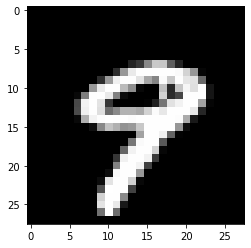

In [23]:
show_img(x_test[9])